In [221]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm 
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap
import scipy
import pandas as pd
from scipy import stats
import MySQLdb as mdb
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from pytz import timezone
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
volume_cryptos = pd.read_pickle('./volume_cryptos.pkl').astype('float')
volume_cryptos.head()

,"(11, 1)","(11, 2)","(11, 3)","(11, 4)","(11, 5)","(11, 6)","(11, 7)","(11, 8)","(11, 9)","(11, 10)",...,"(3, 14)","(3, 15)","(3, 16)","(3, 17)","(3, 18)","(3, 19)","(3, 20)","(3, 21)","(3, 22)","(3, 23)"
0,0.000000,9.524479,27.707678,28.283129,54.985081,78.798522,24.081889,33.292067,63.043501,6.372818,...,152.931687,94.319238,75.450048,1447.099356,1165.970117,300.085494,700.473107,51.864564,147.663626,297.985858
1,43.627570,213.664920,61.867108,21.008396,21.479269,18.575431,77.730586,12.509399,72.715469,6.573682,...,0.000000,53.792684,302.533879,597.365108,227.328293,2080.325992,200.396057,108.703085,197.378476,6.788182
2,11.672195,40.459803,33.227140,8.033916,10.453011,11.514917,203.406252,4.094531,2.226942,4.114936,...,234.485838,203.519174,1660.249400,157.183563,250.954446,276.848736,146.669942,332.711436,100.293547,3743.527994
3,31.100061,5.303673,21.107253,1.757448,168.711860,21.692121,13.902405,54.284584,1.269751,45.762592,...,142.891126,647.076503,553.665784,188.070088,124.122340,368.929888,279.159227,778.891331,17.682221,3288.480868
4,7.156883,3.057171,79.534388,7.339546,24.517245,5.231176,13.127471,12.972374,88.437485,11.079248,...,375.477158,118.862287,182.785104,311.361137,144.336178,172.521523,155.210807,192.128294,51.834116,1558.425188


In [3]:
volume_cryptos.shape

(1440, 144)

In [4]:
volume_days = pd.read_pickle('./volume_days.pkl').astype('float')
volume_days.head()

,BCH-USD,BTC-USD,ETH-USD,LTC-USD
0,63.852539,29.743265,240.679377,360.407982
1,53.226702,24.146439,187.439917,271.830177
2,53.337397,23.349945,225.264167,292.390135
3,45.059222,21.837731,193.611079,230.346888
4,39.475164,15.029650,149.242863,163.770062


In [5]:
volume_days.shape

(1440, 4)

In [21]:
u, sigma, v_t = np.linalg.svd(volume_days, full_matrices=False, compute_uv=True)

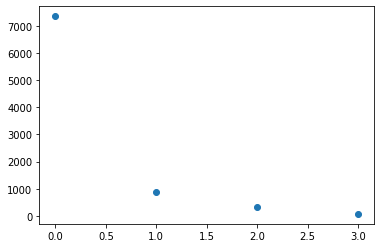

In [22]:
plt.scatter(range(len(sigma)), sigma);

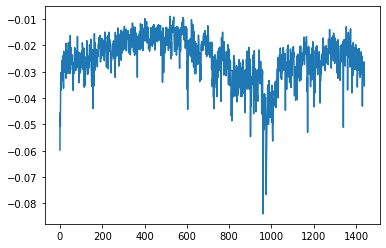

In [23]:
w = u[:, 0]
plt.plot(range(len(w)), w);

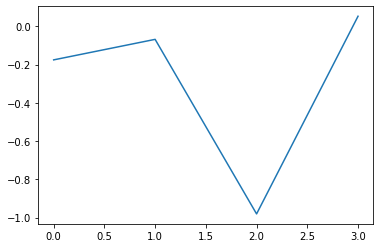

In [25]:
w = v_t[:, 0]
plt.plot(range(len(w)), w);

In [26]:
u, sigma, v_t = np.linalg.svd(volume_cryptos, full_matrices=False, compute_uv=True)

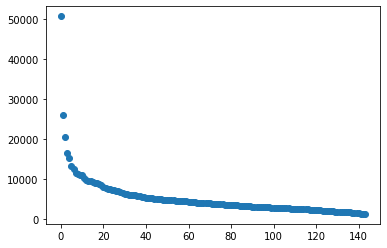

In [27]:
plt.scatter(range(len(sigma)), sigma);

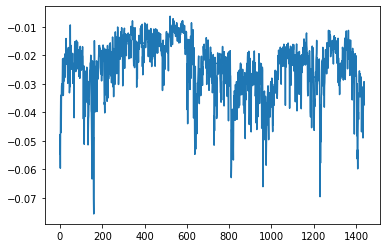

In [28]:
w = u[:, 0]
plt.plot(range(len(w)), w);

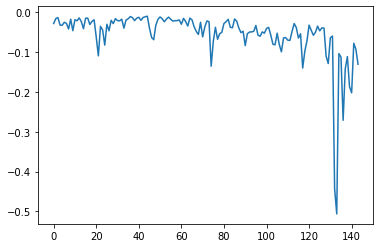

In [29]:
w = v_t[0, :]
plt.plot(range(len(w)), w);

In [30]:
signal = u[:, 0]
v_1 = np.concatenate((signal[:200], signal[600:]))
v_2 = signal[200:600]

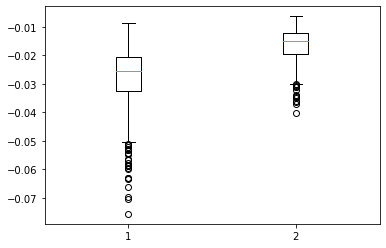

In [31]:
plt.boxplot((v_1, v_2));

In [32]:
stats.mannwhitneyu(v_1, v_2)

MannwhitneyuResult(statistic=57264.0, pvalue=3.1959951951666665e-101)

In [34]:
# Create database connection
db_host = 'localhost'
db_user = 'crypto_user'
db_pass = 'Blue0811'
db_name = 'cryptocurrencies_master'
db_connection = mdb.connect(host=db_host, user=db_user,
                            passwd=db_pass, db=db_name)

In [35]:
end_stamp = 1585008000
with db_connection.cursor() as cur:
    execution_str = 'SELECT price_date, volume \nFROM price_1min \nWHERE id = "BTC-USD" AND '
    execution_str += 'price_date < {}\n'.format(end_stamp)
    execution_str += 'ORDER BY price_date;'
    print('query:\n{}\n'.format(execution_str))
    cur.execute(execution_str)
    data = list(cur.fetchall())
btc_train = pd.DataFrame(data, columns=('timestamp', 'volume'))

query:
SELECT price_date, volume 
FROM price_1min 
WHERE id = "BTC-USD" AND price_date < 1585008000
ORDER BY price_date;



In [36]:
start_stamp = 1585008000
end_stamp = 1585094400
with db_connection.cursor() as cur:
    execution_str = 'SELECT price_date, volume \nFROM price_1min \nWHERE id = "BTC-USD" AND '
    execution_str += '(price_date >= {} AND price_date < {})\n'.format(start_stamp, end_stamp)
    execution_str += 'ORDER BY price_date;'
    print('query:\n{}\n'.format(execution_str))
    cur.execute(execution_str)
    data = list(cur.fetchall())
btc_test = pd.DataFrame(data, columns=('timestamp', 'volume'))

query:
SELECT price_date, volume 
FROM price_1min 
WHERE id = "BTC-USD" AND (price_date >= 1585008000 AND price_date < 1585094400)
ORDER BY price_date;



In [37]:
u_c, sigma_c, vt_c = np.linalg.svd(volume_cryptos, full_matrices=False, compute_uv=True)
u_d, sigma_d, vt_d = np.linalg.svd(volume_days, full_matrices=False, compute_uv=True)

In [38]:
sigma_d_low = sigma_d
sigma_d_low[1:] = 0
A_date = np.matmul(u_d, np.diag(sigma_d_low))
A_date = np.matmul(A_date, vt_d)

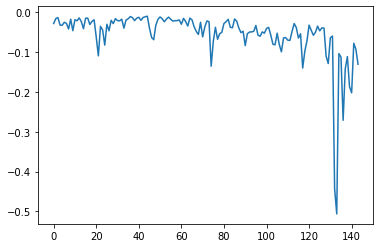

In [52]:
w = vt_c[0, :]
plt.plot(range(len(w)), w);

model = ARIMA(w, order=(5, 2, 0));
model.fit(disp=0);

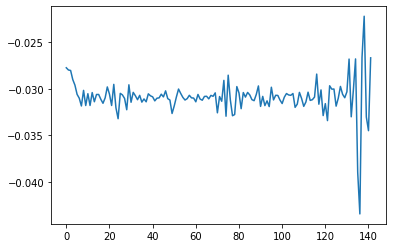

In [53]:
w_pred = model.predict(w)
plt.plot(range(len(w_pred)), w_pred);

In [57]:
model = ARIMA(w, order=(5,2,0));
model_fit = model.fit(disp=0);

In [69]:
predictions = []
N = vt_c.shape[0]
for i in range(N):
    model = ARIMA(vt_c[i, :], order=(5, 2, 0))
    model_fit = model.fit(disp=0)
    pred = model_fit.forecast()[0][0]
    predictions.append(pred)
predictions = np.array(predictions).reshape(-1, 1)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [87]:
vt_c_pred = np.concatenate((vt_c, predictions), axis=1)

sigma_c_low = sigma_c
sigma_c_low[3:] = 0

A_crypto = np.matmul(u_c, np.diag(sigma_c_low))
A_crypto = np.matmul(A_crypto, vt_c_pred)

In [98]:
def stamp_to_trading_day(timestamp):
    date = datetime.fromtimestamp(timestamp).astimezone(timezone('UTC'))
    minute = date.hour*60 + date.minute
    return (date.month, date.day, minute)

In [138]:
def compute_day_index(month, day):
    month_correction = {11: 0, 12: 30, 1: 61, 2: 92, 3: 121}
    index = day - 1 + month_correction[month]
    return index

In [214]:
N = btc_train.shape[0]
X = np.zeros((N, 3))
y_reg = np.zeros((N, 1))
y_class = np.zeros((N, 1))

volume = btc_train['volume']
p_25 = np.percentile(volume, 25)
p_50 = np.percentile(volume, 50)
p_75 = np.percentile(volume, 75)

for i in range(N):
    timestamp = btc_train['timestamp'][i]
    month, day, minute = stamp_to_trading_day(timestamp)
    day_index = compute_day_index(month, day)
    
    v_date = A_date[minute, 1]
    v_crypto = A_crypto[minute, day_index]
    v_mean = A_crypto[minute, :i + 1].mean()
    
    X[i, 0] = v_date - v_mean
    X[i, 1] = v_crypto - v_mean
    X[i, 2] = v_mean
    
    volume = btc_train['volume'][i]
    y_reg[i] = volume
    if volume <= p_25:
        y_class[i] = 0
    elif volume > p_25 and volume <= p_50:
        y_class[i] = 1
    elif volume > p_50 and volume <= p_75:
        y_class[i] = 2
    else:
        y_class[i] = 3

In [215]:
N = X.shape[0]
X_reg = sm.add_constant(X)

In [216]:
lin_reg = sm.OLS(y_reg, X).fit()
print(lin_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.373
Model:                            OLS   Adj. R-squared (uncentered):              0.373
Method:                 Least Squares   F-statistic:                          4.104e+04
Date:                Sat, 28 Mar 2020   Prob (F-statistic):                        0.00
Time:                        12:00:32   Log-Likelihood:                     -9.4604e+05
No. Observations:              206582   AIC:                                  1.892e+06
Df Residuals:                  206579   BIC:                                  1.892e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [218]:
N = int(X.shape[0]*0.8)
X_train = X[:N, :]
X_test = X[N:, :]
y_train = y_class[:N]
y_test = y_class[N:]
log_reg = LogisticRegression().fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [222]:
y_pred = log_reg.predict(X_test)
accuracy_score(y_test, y_pred)

0.5142919379432195

In [220]:
y_pred

array([2., 2., 2., ..., 3., 3., 3.])